# 2D Hydro simulation with Volume penalization method
This notebook aims to show the workflow of setting up aπ Hydro simulation with Volume penalization method in the cylindrical coordinates. ([Morales et al. 2012](https://www.sciencedirect.com/science/article/pii/S002199911400401X))

We pick the classical Taylor Couette experiment in low Re $(Re\sim 1)$ with the comparsion between the analytical and numerical result.

In [1]:
using MHDFlows, PyPlot, CUDA
using LinearAlgebra: mul!, ldiv!

┌ Info: FourierFlows will use 8 threads
└ @ FourierFlows /home/doraho/.julia/packages/FourierFlows/IWexK/src/FourierFlows.jl:123


In [2]:
device!(1)

CuDevice(1): NVIDIA GeForce RTX 2070 SUPER

In [3]:
#parameters
N = 128;
Nz= 4;
Lx = 2π;
ν,η = 1,1;
dt = 2e-4;
# Testing the problem 
nothingfunction(args...) = nothing;
CPUprob = Problem(GPU();
        # Numerical parameters
                      nx = N,
                      Lx = 2π,
                      ny = N,
                      nz = Nz,
         # Drag and/or hyper-viscosity for velocity/B-field
                       ν = ν,
                      nν = 1,
                       η = η,
        # VP method
              VP_method = true,
        # Timestepper and equation options
                      dt = dt,
                 stepper = "RK4",
        # Force Driving parameters       
                   calcF = nothingfunction,
        # Float type and dealiasing
                       T = Float32)

MHDFlows Problem
  │    Funtions
  │     ├──────── B-field: OFF
  ├─────├────── VP Method: ON
  │     ├──────────── Dye: OFF
  │     └── user function: OFF
  │                        
  │     Features           
  │     ├─────────── grid: grid (on GPU)
  │     ├───── parameters: params
  │     ├────── variables: vars
  └─────├─── state vector: sol
        ├─────── equation: eqn
        ├────────── clock: clock
        └──── timestepper: RK4TimeStepper

In [4]:
function ProblemGeneratorTC!(prob;L0=2π,T=Float32)

  # Output Setting  
  x = Array(prob.grid.x);
  y = Array(prob.grid.y);
  z = Array(prob.grid.z);
  nx,ny,nz = prob.grid.nx,prob.grid.ny,prob.grid.nz;
  ux,uy,uz = zeros(T,nx,ny,nz),zeros(T,nx,ny,nz),zeros(T,nx,ny,nz);
  Ux,Uy,Uz = zeros(T,nx,ny,nz),zeros(T,nx,ny,nz),zeros(T,nx,ny,nz);  
  V₀ = 1;
  r₀ = 0.32π;  
    
  # Setup: Uθ = 1 if r ∈ 0.32π
  # Uθ =  r(dθ/dt) ê_θ
  # ̂e_θ  = - sinθ ̂i + cosθ ̂j; 
  χ =  Cylindrical_Mask_Function(prob.grid;R₂=0.82π,R₁=r₀);
  copyto!(prob.params.χ,Array(χ));
  for k ∈ 1:nz,j ∈ 1:ny,i ∈ 1:nx
    r = sqrt(x[i]^2+y[j]^2);
    θ = atan(y[j],x[i]) ;
    θ = isnan(θ) ? π/2 : θ
    sinθ = sin(θ);
    cosθ = cos(θ);
    #sinθ =  θ < 0 ? sin(-θ) : sin(θ)    
    if r <= r₀
        Ux[i,j,k] = -sinθ*r/r₀
        Uy[i,j,k] =  cosθ*r/r₀
    end
        
  end
    
  #Update V + B Conponment to Problem
  SetUpProblemIC!(prob; ux = ux, uy = uy,
                        U₀x= Ux, U₀y= Uy);
      
  return nothing
end

ProblemGeneratorTC! (generic function with 1 method)

In [5]:
# Setting up the Initial condition for both domain
ProblemGeneratorTC!(CPUprob);
Ux,Uy = Array(CPUprob.params.U₀x),Array(CPUprob.params.U₀y);
Ur,Uθ = xy_to_polar(Ux,Uy);

## The Solid Domain and Initial condition illustration

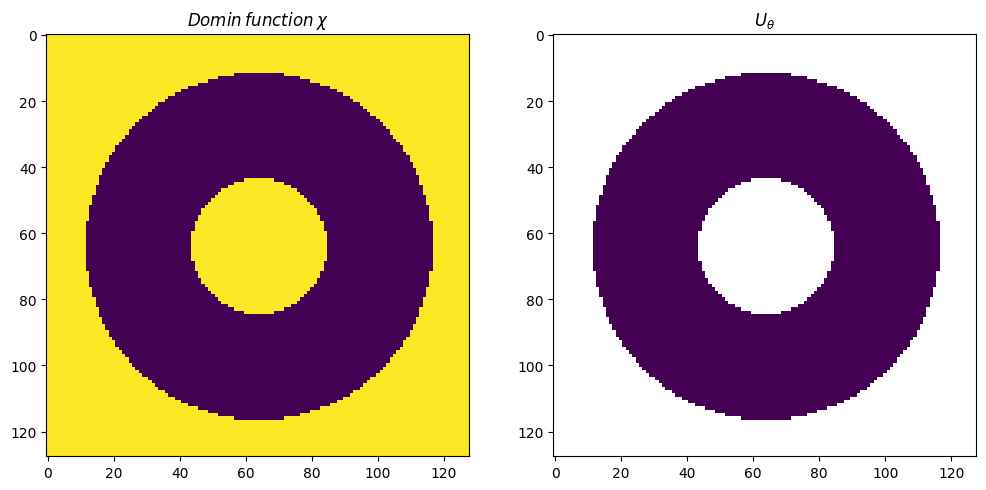

In [6]:
A  = ones(size(Ux));
χ = Array(CPUprob.params.χ);
A[χ.==1].=NaN;
figure(figsize=(12,6))
subplot(121);
imshow(χ[:,:,1]);
title(L"Domin\:function\:\chi");
subplot(122);
imshow((A.*Uθ)[:,:,1]);
title(L"U_\theta");

In [7]:
# Set up the initial condition
@CUDA.time TimeIntegrator!(CPUprob,5.0,50000;
                                 usr_dt = dt,
                                  diags = [],
                            loop_number = 2000)

n =     2000, t =      0.4, KE =     13.6
n =     4000, t =      0.8, KE =     16.4
n =     6000, t =      1.2, KE =     17.1
n =     8000, t =      1.6, KE =     17.2
n =    10000, t =      2.0, KE =     17.2
n =    12000, t =      2.4, KE =     17.2
n =    14000, t =      2.8, KE =     17.2
n =    16000, t =      3.2, KE =     17.2
n =    18000, t =      3.6, KE =     17.2
n =    20000, t =      4.0, KE =     17.2
n =    22000, t =      4.4, KE =     17.2
n =    24000, t =      4.8, KE =     17.2
Total CPU/GPU time run = 290.482 s, zone update per second = 5.640959821e6 
292.189139 seconds (528.47 M CPU allocations: 65.469 GiB, 3.62% gc time) (1.13 M GPU allocations: 279.038 GiB, 0.90% memmgmt time)


# Comparsion Between Numerical & Analytical Soultion 

In [8]:
function TCFlowSolution(L,N;R₁ = 0.32*π, R₂ = 0.95π, Ω₁ = 1, Ω₂ = 0)
    dev  = CPU();
    Lx = Ly = L;
    nx = ny = N;
    T  = Float32;
    grid = TwoDGrid(dev, nx, Lx, ny, Ly; T=T)
    Uθ = zeros(nx,ny)
    for j ∈ 1:ny, i ∈ 1:nx
        r = sqrt(grid.x[i]^2+grid.y[j]^2);
        Uθ[i,j] = (Ω₂*R₂^2 - Ω₁*R₁^2)/(R₂^2-R₁^2)*r + ((Ω₁-Ω₂)*R₁^2*R₂^2)/(R₂^2-R₁^2)/r
    end
    return Uθ    
end

TCFlowSolution (generic function with 1 method)

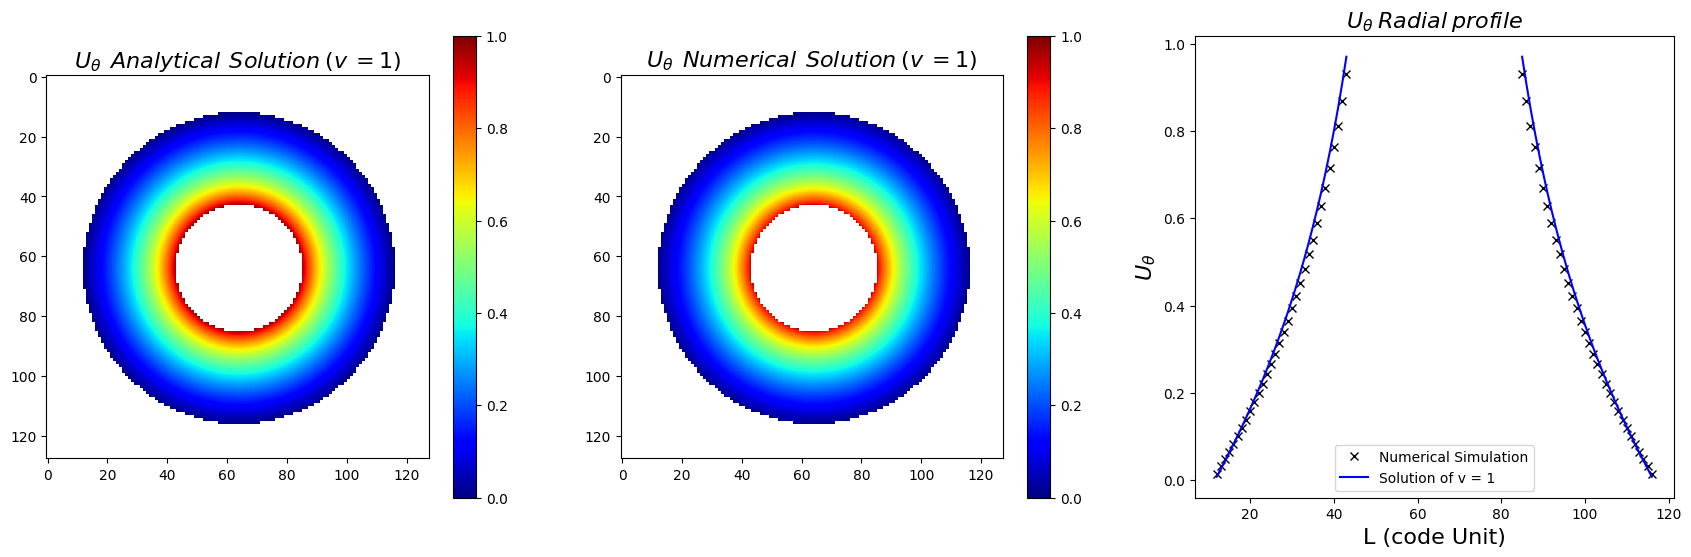

PyObject <matplotlib.legend.Legend object at 0x7fedc08f9c88>

In [10]:
figure(figsize=(21,6))
A  = ones(size(Ux));
A  = ones(size(Ux));
χ = CPUprob.params.χ;
A[χ.==1].=NaN;
subplot(131)
title(L"U_\theta\:\:Analytical\:\:Solution\:(v\:= 1)",size=16)
Lx,nx = 2π,128;
TA = TCFlowSolution(Lx,nx;R₁ = 0.32*π, R₂ = 0.82π, Ω₁ = 1, Ω₂ = 0)
TA = (A[:,:,1]).*TA;
imshow(TA,cmap="jet",vmin=0,vmax=1);colorbar()


subplot(132)
title(L"U_\theta\:\:Numerical\:\:Solution\:(v\:= 1)",size=16)
Ux,Uy = Array(CPUprob.vars.ux),Array(CPUprob.vars.uy);
Ur,Uθ = xy_to_polar(Ux,Uy);
TN = (A.*Uθ)[:,:,1];
imshow(TN,cmap="jet",vmin=0,vmax=1);colorbar()


subplot(133)
AA = (A.*TA);
NN = (A.*TN);
title(L"U_\theta\:Radial\:profile",size=16)
plot(NN[:,64,1],"kx",label="Numerical Simulation")
plot(AA[:,64,1],"b-",label="Solution of v = 1")
xlabel("L (code Unit)",size=16)
ylabel(L"U_{\theta}",size=16)
legend()